In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import time
import math
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from utils import *
from preprocessing import load_data
from RandomFeats import define_rand_feats
from ClusterMLP import mlp_main, generate

In [2]:
### CONFIG
task = 'potency'
K = 64 # Num pca components
p = 0.3 # Upper pth percentile for subsets
c = 24 # Num clusters
N = 1280 # Num betas to fit (Typically 512 or 1280)
M = 25_000 # Num betas to generate
batch_size = 64
nclust_values = [1, 5, 25, 101, 251] # Number clusters to use for each datapoints personalized ensemble

In [3]:
data = load_data(task, K)

In [4]:
np.random.seed(74)
X, _ = data['train']
D = K * 5
model = define_rand_feats(X, D)

In [8]:
kmeans = KMeans(n_clusters=c, random_state=0)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

In [6]:
### Load sample betas and dirs
id_str = f"{task}-N{N}-D{D}-p{p}-c{c}-pca{K}"
subs = np.load('sample_data/clustering/fit/' + id_str + '-subs.npy')
betas = np.load('sample_data/clustering/fit/' + id_str + '-betas.npy')

print(subs.shape)
print(betas.shape)

(1280, 24)
(1280, 3201)


In [9]:
# Beta Model
mlp_ret = mlp_main(np.array(subs), np.array(betas), X, model(X), labels)
print(f"MLP Metrics:\n\tTest Loss - {mlp_ret['test_loss']}\n\Agreement: Overall - {mlp_ret['overall_agreement']}, Subset - {mlp_ret['subset_agreement']}")

Epoch 1/10


c:\ProgramData\anaconda3\envs\EveryDirHoldsSoln\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0959
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0625
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0541
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0512
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0492
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0480
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0471
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0465
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0460
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0458
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MLP Metrics:
	Test Loss - 0.04097422584891319
\Agreement: Overall - 0.7815111549137728, Subset - 0.7784636408445049


In [10]:
# Draw new betas
gen_subs, gen_betas = generate(mlp_ret['mlp'], M, c)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [11]:
X_iid, Y_iid = data['iid_val']
X_ood_val, Y_ood_val = data['ood_val']
X_ood_test, Y_ood_test = data['ood_test']

X_iid_rand = model(X_iid)
X_ood_val_rand = model(X_ood_val)
X_ood_test_rand = model(X_ood_test)

In [12]:
def get_nearest_t_clusters(x, centers, t):
  # Calc distnace between point and each cluster center
  distances = np.linalg.norm(centers - x, axis=1)
  # Get idxs of nearest t clusters
  return np.argsort(distances)[:t]

In [18]:
T = [1, 5, 11, 21, 51, 101]
t = 12 # Nearest half clusters to x

print(p*gen_subs.shape[1])

p_hat = p*gen_subs.shape[1]/t
print(p_hat)

7.199999999999999
0.6


In [19]:
def clst_ens(X, X_rand, Y, mlp, centers, t, T, p_hat, ):
    start_time = time.time()

    accs = np.zeros((X.shape[0], len(T)))
    print(accs.shape)
    i = 0
    for x, x_rand, y in zip(X, X_rand, Y):
        if i % 250 == 0:
            print(f"Step {i}")
            curr_time = time.time()
            elapsed_time = (curr_time - start_time)/60 # min
            print(f"\tTime Elapsed: {elapsed_time:.2f} min - est {elapsed_time/(i + 1)*6567 - elapsed_time:.2f}")
        nearest_idxs = get_nearest_t_clusters(x, centers, t)
        # Gen T bin vectors
        bin_vecs = []
        for _ in range(T[-1]):
            bin_vec = np.zeros(gen_subs.shape[1])
            bin_vec[nearest_idxs] = np.random.binomial(1, p_hat, t)
            bin_vecs.append(bin_vec)
        bin_vecs = np.array(bin_vecs)

        betas = mlp.predict(bin_vecs, verbose=0)
        x_rand = np.concatenate([np.ones(1), x_rand], axis=0)
        prds = 1 / (1 + np.exp(-x_rand @ betas.T))
        prds = (prds > 0.5).astype(int)
        for j, T_ in enumerate(T):
            prd = np.mean(prds[:T_]) > 0.5
            acc = int(prd == y)
            accs[i, j] = acc
        i += 1
    return accs

def plot(T, accs):
    T_accs = np.mean(accs, axis=0)
    plt.plot(T, T_accs, marker='o')  # Plot with markers at each point
    plt.xlabel('T values')            # Set the x-axis label
    plt.ylabel('Accuracy')            # Set the y-axis label
    plt.title('Accuracy vs Num Models')  # Set the title of the graph
    plt.grid(True)                    # Add a grid for better readability
    plt.show()

In [21]:
iid_acc = clst_ens(X_iid, X_iid_rand, Y_iid, mlp_ret['mlp'], centers, t, T, p_hat)

(4230, 6)
Step 0
	Time Elapsed: 0.00 min - est 0.11
Step 250
	Time Elapsed: 0.32 min - est 7.96
Step 500
	Time Elapsed: 0.61 min - est 7.41
Step 750
	Time Elapsed: 0.93 min - est 7.21
Step 1000
	Time Elapsed: 1.25 min - est 6.97
Step 1250
	Time Elapsed: 1.51 min - est 6.42
Step 1500
	Time Elapsed: 1.77 min - est 5.97
Step 1750
	Time Elapsed: 2.03 min - est 5.57
Step 2000
	Time Elapsed: 2.28 min - est 5.21
Step 2250
	Time Elapsed: 2.54 min - est 4.87
Step 2500
	Time Elapsed: 2.79 min - est 4.54
Step 2750
	Time Elapsed: 3.05 min - est 4.23
Step 3000
	Time Elapsed: 3.30 min - est 3.93
Step 3250
	Time Elapsed: 3.56 min - est 3.63
Step 3500
	Time Elapsed: 3.82 min - est 3.35
Step 3750
	Time Elapsed: 4.08 min - est 3.06
Step 4000
	Time Elapsed: 4.34 min - est 2.78


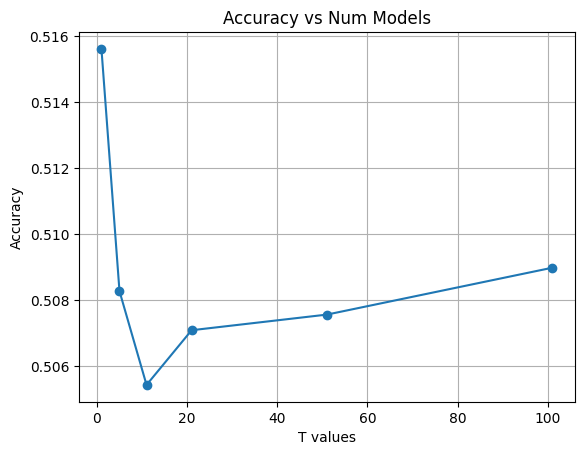

In [22]:
plot(T, iid_acc)

In [23]:
ood_val_acc = clst_ens(X_ood_val, X_ood_val_rand, Y_ood_val, mlp_ret['mlp'], centers, t, T, p_hat)

(6567, 6)
Step 0
	Time Elapsed: 0.00 min - est 0.00
Step 250
	Time Elapsed: 0.25 min - est 6.35
Step 500
	Time Elapsed: 0.50 min - est 6.11
Step 750
	Time Elapsed: 0.76 min - est 5.86
Step 1000
	Time Elapsed: 1.02 min - est 5.66
Step 1250
	Time Elapsed: 1.28 min - est 5.43
Step 1500
	Time Elapsed: 1.53 min - est 5.16
Step 1750
	Time Elapsed: 1.79 min - est 4.91
Step 2000
	Time Elapsed: 2.05 min - est 4.68
Step 2250
	Time Elapsed: 2.31 min - est 4.43
Step 2500
	Time Elapsed: 2.57 min - est 4.17
Step 2750
	Time Elapsed: 2.82 min - est 3.92
Step 3000
	Time Elapsed: 3.08 min - est 3.66
Step 3250
	Time Elapsed: 3.33 min - est 3.40
Step 3500
	Time Elapsed: 3.59 min - est 3.15
Step 3750
	Time Elapsed: 3.86 min - est 2.90
Step 4000
	Time Elapsed: 4.11 min - est 2.64
Step 4250
	Time Elapsed: 4.36 min - est 2.38
Step 4500
	Time Elapsed: 4.62 min - est 2.12
Step 4750
	Time Elapsed: 4.88 min - est 1.86
Step 5000
	Time Elapsed: 5.13 min - est 1.61
Step 5250
	Time Elapsed: 5.38 min - est 1.35
Step 5

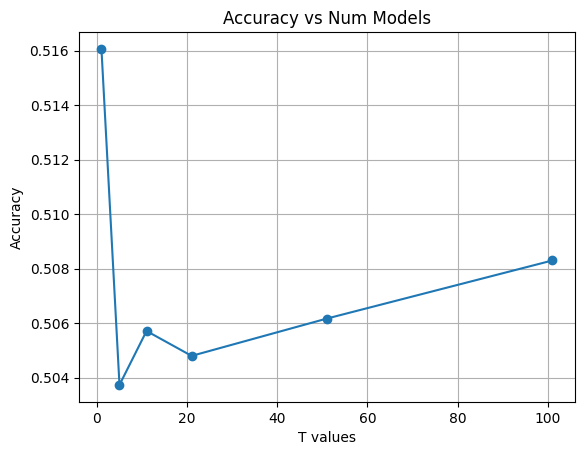

In [24]:
plot(T, ood_val_acc)

In [25]:
ood_test_acc = clst_ens(X_ood_test, X_ood_test_rand, Y_ood_test, mlp_ret['mlp'], centers, t, T, p_hat)

(6924, 6)
Step 0
	Time Elapsed: 0.00 min - est 0.16
Step 250
	Time Elapsed: 0.25 min - est 6.38
Step 500
	Time Elapsed: 0.50 min - est 6.11
Step 750
	Time Elapsed: 0.76 min - est 5.89
Step 1000
	Time Elapsed: 1.03 min - est 5.70
Step 1250
	Time Elapsed: 1.29 min - est 5.46
Step 1500
	Time Elapsed: 1.54 min - est 5.21
Step 1750
	Time Elapsed: 1.80 min - est 4.95
Step 2000
	Time Elapsed: 2.06 min - est 4.69
Step 2250
	Time Elapsed: 2.31 min - est 4.44
Step 2500
	Time Elapsed: 2.57 min - est 4.18
Step 2750
	Time Elapsed: 2.83 min - est 3.92
Step 3000
	Time Elapsed: 3.09 min - est 3.67
Step 3250
	Time Elapsed: 3.34 min - est 3.41
Step 3500
	Time Elapsed: 3.60 min - est 3.15
Step 3750
	Time Elapsed: 3.85 min - est 2.89
Step 4000
	Time Elapsed: 4.11 min - est 2.63
Step 4250
	Time Elapsed: 4.36 min - est 2.38
Step 4500
	Time Elapsed: 4.62 min - est 2.12
Step 4750
	Time Elapsed: 4.87 min - est 1.86
Step 5000
	Time Elapsed: 5.13 min - est 1.61
Step 5250
	Time Elapsed: 5.38 min - est 1.35
Step 5

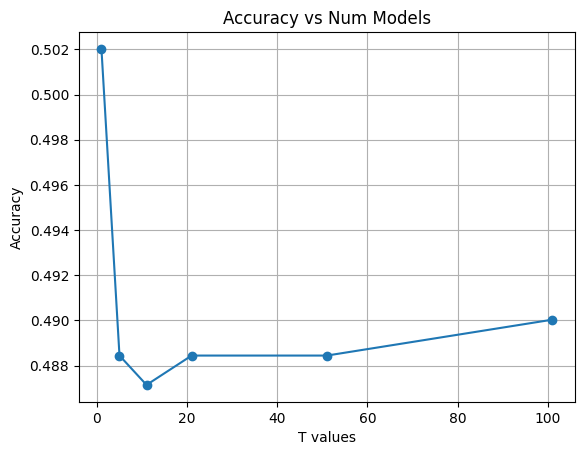

In [26]:
plot(T, ood_test_acc)